In [1]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps

# Searching for the Higgs boson

In [2]:
Higgs_Mass = 125.1  # In Units of MeV / c**2
Higgs_Width = 4.2   # In Units of MeV / c**2

mass_grid = np.linspace(100., 160., 61)

In [3]:
from functools import partial

def Gauss(x, nsig, mu, sigma):
    return nsig*sps.norm(loc=mu, scale=sigma).pdf(x)

def poly1(x, ref_mass, offset, slope):
    return offset + (x-ref_mass)*slope

def model_func(x, ref_mass, nsig, mu, sigma, offset, slope):
    return Gauss(x, nsig, mu, sigma) + poly1(x, ref_mass, offset, slope)

def generic_chi2(params, data_vals, model, x, ref_mass):
    model_vals = model(x, ref_mass, *params)
    return np.sum((data_vals - model_vals)**2)

def cost_func(data_vals, model, x, ref_mass):
    return partial(generic_chi2, data_vals=data_vals, model=model, x=x, ref_mass=ref_mass)

In [4]:
ref_mass = 130.
nsig_per_month = 30.
nbkg_per_mev_per_month = 40.
bkg_slope_per_mev_per_month = -0.2

In [5]:
model_bkg = poly1(mass_grid, ref_mass, nbkg_per_mev_per_month, bkg_slope_per_mev_per_month)
model_sig = Gauss(mass_grid, nsig_per_month, Higgs_Mass, Higgs_Width)

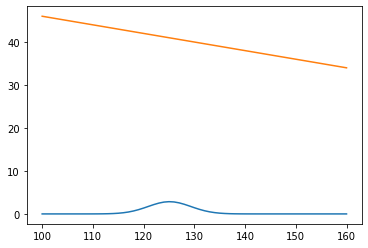

In [6]:
_ = plt.plot(mass_grid, model_sig)
_ = plt.plot(mass_grid, model_bkg)

In [7]:
def passed_cuts(cut_width, mass_grid, model_sig, model_bkg):
    mask = np.abs(mass_grid - 125) < cut_width
    n_sig = np.sum(model_sig[mask])
    n_bkg = np.sum(model_bkg[mask])
    return n_sig, n_bkg

In [8]:
def plot_nexp(mass_grid, model_sig, model_bkg):
    sig_cts = np.zeros(26)
    bkg_cts = np.zeros(26)
    widths = np.linspace(0, 25, 26)
    for i, width in enumerate(widths):
        sig_cts[i], bkg_cts[i] = passed_cuts(width, mass_grid, model_sig, model_bkg)
    _ = plt.plot(widths, sig_cts)
    _ = plt.plot(widths, bkg_cts)
    _ = plt.yscale('log')

In [9]:
def find_sig2noise(mass_grid, model_sig, model_bkg, plot=True):
    sig_cts = np.zeros(26)
    bkg_cts = np.zeros(26)
    widths = np.linspace(0, 25, 26)
    for i, width in enumerate(widths):
        if i == 0:
            continue
        sig_cts[i], bkg_cts[i] = passed_cuts(width, mass_grid, model_sig, model_bkg)
    sig2noise = np.zeros(26)
    sig2noise[1:] = sig_cts[1:]/np.sqrt(bkg_cts[1:])
    if plot:
        _ = plt.plot(widths, sig_cts/np.sqrt(bkg_cts))
    return sig2noise

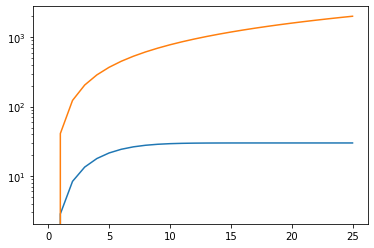

In [10]:
plot_nexp(mass_grid, model_sig, model_bkg)

<ipython-input-9-bc2000377dce>:12: RuntimeWarning: invalid value encountered in true_divide
  _ = plt.plot(widths, sig_cts/np.sqrt(bkg_cts))


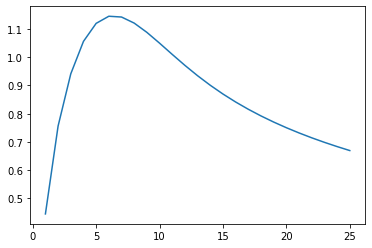

In [11]:
_ = find_sig2noise(mass_grid, model_sig, model_bkg)

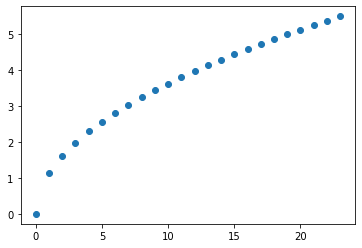

In [12]:
max_s2n = np.zeros(24)
best_cut = np.zeros(24)
n_months_array = np.arange(24)
for n_months in n_months_array:
    if n_months == 0:
        continue
    s2n = find_sig2noise(mass_grid, n_months*model_sig, n_months*model_bkg, plot=False)
    max_s2n[n_months] = np.max(s2n)
    best_cut[n_months] = np.argmax(s2n)
_ = plt.scatter(n_months_array, max_s2n)

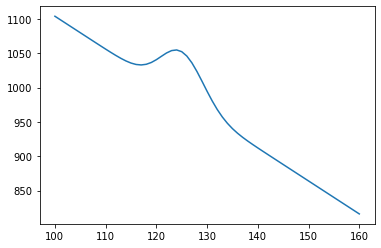

In [13]:
_ = plt.plot(mass_grid, 24*(model_sig+model_bkg))

In [14]:
tot_model = np.random.poisson(24*(model_sig+model_bkg))

In [23]:
os.unlink('Higgs.txt')
fout = open('Higgs.txt', 'w')
fout.write("# Mass     Nevts\n")
for mass, nevt in zip(mass_grid, tot_model):
    fout.write("%0.1f %i\n" % (mass, nevt))
fout.close()

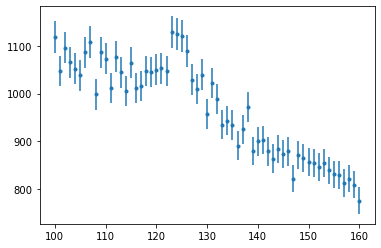

In [26]:
data = np.loadtxt('Higgs.txt')
masses = data[:,0]
nevts = data[:,1]
errors = np.sqrt(nevts)
_ = plt.errorbar(masses, nevts, yerr=errors, fmt='.')

In [25]:
mask_bkg_lo = np.bitwise_and(masses > 99.5, masses < 111.5) 
mask_bkg_hi = np.bitwise_and(masses > 138.5, masses < 150.5) 
mask_bkg = np.bitwise_or(mask_bkg_lo, mask_bkg_hi)
bkg_estimate = np.sum(nevts[mask_bkg])* (11/24)
print(bkg_estimate)
print(np.sqrt(bkg_estimate))
mask_sig = np.abs(masses - 125) <= 5.5
sig_estimate = np.sum(nevts[mask_sig])
print(sig_estimate)

10659.458333333332
103.24465280746182
11646.0


In [27]:
def plotModels(masses, counts, ref_mass, init_pars):
    
    model_vals = model_func(masses, counts, ref_mass, *init_pars)
    background_vals = poly1(masses, counts, ref_mass, init_pars[3], init_pars[4])

    _ = plt.plot(masses, counts, label="data")
    _ = plt.plot(masses, background_vals, label="background model")
    _ = plt.plot(masses, model_vals, label="model")
    _ = plt.xlabel(r'$m [MeV / c^2]$')
    _ = plt.ylabel(r'Counts [per MeV / c^2]')
    _ = plt.legend()

In [ ]:
def fitAndPlotResult(masses, nevts, ref_masss, init_pars):
    our_cost_func = cost_func(masses, model_func, nevts, ref_lambda=ref_lambda)
    result = optimize.minimize(our_cost_func, x0=np.array(init_pars))
    fit_parspars = result['x']
    model_fit = model_func(masses, nevts, *fit_pars)
    background_fit = poly1(masses, nevts, fit_pars[3], fit_pars[4])
    print("Best Fit ---------")
    print("Line Intensity: %.1f [arcane units]" % fit_pars[0])
    print("Line Peak: %.4f [nm]" % fit_pars[1])
    print("Line Width: %.4f [nm]" % fit_pars[2])
    print("Background at 500 nm: %.2f [arcane units]" % fit_pars[3])
    print("Background slope: %.2f [arcane_units / nm]" % fit_pars[4])
    _ = plt.plot(masses, cutout_flux, label="data")
    _ = plt.plot(masses, background_fit, label="background model")
    _ = plt.plot(masses, model_fit, label="full model")
    _ = plt.xlabel(r"$\lambda [nm]$")
    _ = plt.ylabel("Flux [arcane units]")
    _ = plt.legend()